# Practice notebook for confidence intervals using NHANES data

This notebook will give you the opportunity to practice working with confidence intervals using the NHANES data.

You can enter your code into the cells that say "enter your code here", and you can type responses to the questions into the cells that say "Type Markdown and Latex".

Note that most of the code that you will need to write below is very similar to code that appears in the case study notebook.  You will need to edit code from that notebook in small ways to adapt it to the prompts below.

To get started, we will use the same module imports and read the data in the same way as we did in the case study:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

da = pd.read_csv("nhanes_2015_2016.csv")

## Question 1

Restrict the sample to women between 35 and 50, then use the marital status variable [DMDMARTL](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#DMDMARTL) to partition this sample into two groups - women who are currently married, and women who are not currently married.  Within each of these groups, calculate the proportion of women who have completed college.  Calculate 95% confidence intervals for each of these proportions.

In [60]:
# enter your code here

# making data human readable
da["RIAGENDRx"] = da.RIAGENDR.replace({1: "Male", 2: "Female"})

# extrapoliting female
dfemale = da[da['RIAGENDRx'] == 'Female']

# extrapolating age range between 35 and 50
dfemale['agerange'] = pd.cut(dfemale['RIDAGEYR'], (35,50))
dfemale_age = dfemale[dfemale['agerange'].notna()]

# making data human readable again (have to go over this again to know why regex doesn't work)
dfemale_age['DMDMARTL'] = dfemale_age['DMDMARTL'].replace({1: 'Married', 2: 'Not_Married', 3: 'Not_Married', 4: 'Not_Married', 5: 'Not_Married', 6: 'Not_Married', 77: np.nan, 99: np.nan})
dfemale_age['DMDEDUC2'] = dfemale_age['DMDEDUC2'].replace({5: 'Graduated', 1: 'Not_Graduated', 2: 'Not_Graduated', 3: 'Not_Graduated', 4: 'Not_Graduated', 9: np.nan})

# dropping nan values
data_clean = dfemale_age[['DMDMARTL', 'DMDEDUC2', 'RIAGENDRx']].dropna()

# creating crosstab
crosstab = pd.crosstab(data_clean.DMDEDUC2, data_clean.DMDMARTL)
print(crosstab)

DMDMARTL       Married  Not_Married
DMDEDUC2                           
Graduated          154           67
Not_Graduated      265          254


In [4]:
# calculating sample proportion of graduated and sample size
prop_total = data_clean.groupby(data_clean.DMDMARTL).agg({"DMDEDUC2": [lambda x: np.mean(x=="Graduated"), np.size]})
prop_total.columns = ["Proportion", "Total_n"]
print(prop_total)

             Proportion  Total_n
DMDMARTL                        
Married        0.367542      419
Not_Married    0.208723      321


In [63]:
p1 = prop_total.Proportion.Married # Married proportion
n1 = prop_total.Total_n.Married # Total number of married
se_married = np.sqrt(p1 * (1 - p1) / n1)
print(f'Married standard error: {se_married}')

p2 = prop_total.Proportion.Not_Married # Not married proportion
n2 = prop_total["Total_n"].Not_Married # Total number of not married
se_not_married = np.sqrt(p2 * (1 - p2) / n2)
print(f'Not married standard error: {se_not_married}')

# calculating confidence interval for married (double calculation, just in case)
ci_married = sm.stats.proportion_confint(154, 154+265)
low_cil_married = p1 - 1.96 * np.sqrt(p1 * (1 - p1) / n1)
upp_cil_married = p1 + 1.96 * np.sqrt(p1 * (1 - p1) / n1)

# calculating confidence interval for unmarried
ci_not_married = sm.stats.proportion_confint(67, 67+254)
low_cil_notmarried = p2 - 1.96 * np.sqrt(p2 * (1 - p2) / n2)
upp_cil_notmarried = p2 + 1.96 * np.sqrt(p2 * (1 - p2) / n2)


print(f'Confidence interval for married is between: {ci_married}')
# print(low_cil_married, upp_cil_married) to check if the calculation is correct
print(f'Confidence interval for not married is between: {ci_not_married}')
# print(low_cil_notmarried, upp_cil_notmarried)

Married standard error: 0.02355386941414772
Not married standard error: 0.022682802482912778
Confidence interval for married is between: (0.3213770303614961, 0.41370650185807434)
Confidence interval for not married is between: (0.16426526549807702, 0.2531802173679666)


__Q1a.__ Identify which of the two confidence intervals is wider, and explain why this is the case. 

Not married has a wider confidence interval because the sample is smaller

__Q1b.__ Write 1-2 sentences summarizing these findings for an audience that does not know what a confidence interval is (the goal here is to report the substance of what you learned about how marital status and educational attainment are related, not to teach a person what a confidence interval is).

We can see that the proportion of graduated married woman is around 36%, bigger than the proportion of unmarried graduated woman, which is around 20%. This can leads us to think that a married woman has more chance of getting a college degree than a not married one. Anyway, we have to consider that we choose to look at wether the women were married at the time of the survey, not at the time of their graduation, and this can lead to some biases in the calculation.

## Question 2

Construct 95% confidence intervals for the proportion of smokers who are female, and for the proportion of smokers who are male.  Then construct a 95% confidence interval for the difference between these proportions.

In [93]:
# enter your code here

# making data human readable
da["SMQ020x"] = da.SMQ020.replace({1: "Yes", 2: "No", 7: np.nan, 9: np.nan})  # np.nan represents a missing value

# creating parsed dataframe and proportion
smoke = da[['RIAGENDRx', 'SMQ020x']].dropna()
smoker = smoke.groupby('RIAGENDRx')['SMQ020x'].agg([lambda x: np.mean(x == 'Yes'), 'size'])
smoker.columns = ['Proportion', 'Size']
print(smoker)

# creating crosstab
smoker_crosstab = pd.crosstab(smoke['RIAGENDRx'], smoke['SMQ020x'])
print('\n', smoker_crosstab, '\n')

# calculating standard errors
p_male = smoker.Proportion.Male
n_male = smoker.Size.Male
se_male = np.sqrt(p_male * (1 - p_male) / n_male)
print(f'Standard error for male smokers is {se_male}')

p_female = smoker.Proportion.Female
n_female = smoker.Size.Female
se_female = np.sqrt(p_female * (1 - p_female) / n_female)
print(f'Standard error for female smokers is :{se_female}')

# calculating confidence interval
ci_male = sm.stats.proportion_confint(1413, 1340+1413)
ci_female = sm.stats.proportion_confint(906, 2066+906)
print(f'Male confidence interval: {ci_male}')
print(f'Female confidence interval: {ci_female}')

se_diff = np.sqrt(se_female**2 + se_male**2)
prop_diff = smoker.Proportion.Female - smoker.Proportion.Male
lcb = prop_diff - 2*se_diff
ucb = prop_diff + 2*se_diff
print(f'Confidence interval for the difference is between {lcb} and {ucb}')

           Proportion  Size
RIAGENDRx                  
Female       0.304845  2972
Male         0.513258  2753

 SMQ020x      No   Yes
RIAGENDRx            
Female     2066   906
Male       1340  1413 

Standard error for male smokers is 0.009526078653689868
Standard error for female smokers is :0.008444152146214435
Male confidence interval: (0.49458749263718593, 0.5319290347874418)
Female confidence interval: (0.2882949879861214, 0.32139545615923526)
Confidence interval for the difference is between -0.2338728044024504 and -0.18295327887682067


__Q2a.__ Discuss why it may be relevant to report the proportions of smokers who are female and male, and contrast this to reporting the proportions of males and females who smoke.

This will allow us to look at the same data from two different perspective: considering only a smoking sample, we can look at the proportions between males and females, and considering the proportions of male and females who smokes can give us insight about which gender smokes the most.

__Q2b.__ How does the width of the confidence interval for the difference of the two proportions compare to the widths of the confidence intervals for each proportion separately?

The width of the confidence interval for the difference is slightly bigger than each of the separates ones. This is probabilly because we have to account two different proportions, anyway our mean falls again into the confidence interval.

## Question 3

Construct a 95% interval for height ([BMXHT](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXHT)) in centimeters.  Then convert height from centimeters to inches by dividing by 2.54, and construct a 95% confidence interval for height in inches.  Finally, convert the endpoints (the lower and upper confidence limits) of the confidence interval from inches to back to centimeters   

In [100]:
# enter your code here

# calculating mean, sample size and standard deviation
height_mean = da['BMXHT'].mean()
height_n = da['BMXHT'].count()
height_std = np.std(da['BMXHT'])

# calculating standard error of the mean
se = height_std / np.sqrt(height_n)

# calculating lower and upper confidence interval points
low_cil = height_mean - 1.96 * se
print(round(low_cil, 2))
upp_cil = height_mean + 1.96 * se
print(round(upp_cil, 2))



165.88
166.41


In [101]:
# converting cm to inches
height_inches = da['BMXHT'] / 2.54

#calculating mean, standard deviation and sample size (should be the same as before)
inches_mean = height_inches.mean()
inches_std = np.std(da['BMXHT'])
inches_n = da['BMXHT'].count()

# calculating standard error
se_inches = inches_std / np.sqrt(inches_n)

# calculating lower and upper confidence interval points
low_cil_inches = inches_mean - 1.96 * se_inches
print(round(low_cil_inches, 2))
upp_cil_inches = inches_mean + 1.96 * se_inches
print(round(upp_cil_inches, 2))

# converting back to cm
print(low_cil_inches * 2.54)
print(upp_cil_inches * 2.54)

65.15
65.67
165.4766815778847
166.8089873803376


__Q3a.__ Describe how the confidence interval constructed in centimeters relates to the confidence interval constructed in inches.

There is a small difference between the two, I guess it's because of rounding during the calculation.

## Question 4

Partition the sample based on 10-year age bands, i.e. the resulting groups will consist of people with ages from 18-28, 29-38, etc. Construct 95% confidence intervals for the difference between the mean BMI for females and for males within each age band.

Text(0, 0.5, 'Female - male BMI difference')

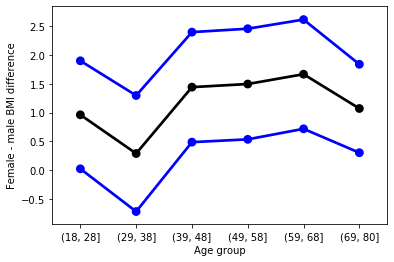

In [10]:
# enter your code here

# setting bins
bins = pd.IntervalIndex.from_tuples([(18, 28), (29, 38), (39, 48), (49, 58), (59, 68), (69, 80)])

# creating age groups
da["agegrp"] = pd.cut(da.RIDAGEYR, bins)

# creating dataframe to work on
pr = da.groupby(["agegrp", "RIAGENDRx"]).agg({"BMXBMI": [np.mean, np.std, np.size]}).unstack()

# Calculate the SEM for females and for males within each age band
pr["BMXBMI", "sem", "Female"] = pr["BMXBMI", "std", "Female"] / np.sqrt(pr["BMXBMI", "size", "Female"]) 
pr["BMXBMI", "sem", "Male"] = pr["BMXBMI", "std", "Male"] / np.sqrt(pr["BMXBMI", "size", "Male"]) 

# Calculate the mean difference of BMI between females and males within each age band, also  calculate
# its SE and the lower and upper limits of its 95% CI.
pr["BMXBMI", "mean_diff", ""] = pr["BMXBMI", "mean", "Female"] - pr["BMXBMI", "mean", "Male"]
pr["BMXBMI", "sem_diff", ""] = np.sqrt(pr["BMXBMI", "sem", "Female"]**2 + pr["BMXBMI", "sem", "Male"]**2) 
pr["BMXBMI", "lcb_diff", ""] = pr["BMXBMI", "mean_diff", ""] - 1.96 * pr["BMXBMI", "sem_diff", ""] 
pr["BMXBMI", "ucb_diff", ""] = pr["BMXBMI", "mean_diff", ""] + 1.96 * pr["BMXBMI", "sem_diff", ""]

# Plot the mean difference in black and the confidence limits in blue
x = np.arange(pr.shape[0])
pp = sns.pointplot(x, pr["BMXBMI", "mean_diff", ""], color='black')
sns.pointplot(x, pr["BMXBMI", "lcb_diff", ""], color='blue')
sns.pointplot(x, pr["BMXBMI", "ucb_diff", ""], color='blue')
pp.set_xticklabels(pr.index)
pp.set_xlabel("Age group")
pp.set_ylabel("Female - male BMI difference")

__Q4a.__ How do the widths of these confidence intervals differ?  Provide an explanation for any substantial diferences in the confidence interval widths that you see.

## Question 5

Construct a 95% confidence interval for the first and second systolic blood pressure measures, and for the difference between the first and second systolic blood pressure measurements within a subject.

In [109]:
# enter code here

# loading the data
blood_df = pd.read_csv("blood_pressure.csv")

# calculating mean, sample size and standard deviation for the first blood pressure measure
first_mean = blood_df['bp_before'].mean()
first_n = blood_df['bp_before'].count()
first_std = np.std(blood_df['bp_before'])

# calculating standard error
se_first = first_std / np.sqrt(first_n)

# calculating lower and upper confidence interval points
low_cil_first = first_mean - 1.96 * se_first
upp_cil_first = first_mean + 1.96 * se_first
print(f'Confidence interval for the first measure is between {low_cil_first} and {upp_cil_first}')

# calculating mean, sample size and standard deviation for the second blood pressure measure
second_mean = blood_df['bp_after'].mean()
second_n = blood_df['bp_after'].count()
second_std = np.std(blood_df['bp_after'])

# calculating standard error
se_second = second_std / np.sqrt(second_n)

# calculating lower and upper confidence interval points
low_cil_second = second_mean - 1.96 * se_second
upp_cil_second = second_mean + 1.96 * se_second
print(f'Confidence interval for the second measure is between {low_cil_second} and {upp_cil_second}')


Confidence interval for the first measure is between 154.42060715976427 and 158.4793928402357
Confidence interval for the second measure is between 148.8322265441842 and 153.88444012248243


In [110]:
# creating a new column with the difference between the two measures for every patient
blood_df['bp_difference'] = blood_df['bp_before'] - blood_df['bp_after']

# calculating mean, sample size and standard deviation for difference
difference_mean = blood_df['bp_difference'].mean()
difference_n = blood_df['bp_difference'].count()
difference_std = np.std(blood_df['bp_difference'])

# calculating standard error
se_difference = difference_std / np.sqrt(difference_n)

# calculating lower and upper confidence interval points
low_cil_difference = difference_mean - 1.96 * se_difference
upp_cil_difference = difference_mean + 1.96 * se_difference
print(f'Confidence interval for the difference between the two measures for every subject is between {low_cil_difference} and {upp_cil_difference}')


Confidence interval for the difference between the two measures for every subject is between 2.113710208667198 and 8.069623124666135


__Q5a.__ Based on these confidence intervals, would you say that a difference of zero between the population mean values of the first and second systolic blood pressure measures is consistent with the data?

Our confidence interval for the difference is between 2 and 8 (rounded), so a difference of 0 wouldn't be consistent with the data we have.


__Q5b.__ Discuss how the width of the confidence interval for the within-subject difference compares to the widths of the confidence intervals for the first and second measures.

The width of the confidence interval for the difference is around 6, for the first measures is around 4 and for the second measures around 5

## Question 6

Construct a 95% confidence interval for the mean difference between the average age of a smoker, and the average age of a non-smoker.

In [118]:
# insert your code here

# creating the dataframe
smoke_age = da[['RIDAGEYR', 'SMQ020x']].dropna()

# calculating mean age of smokers, sample size, standard deviation and standard error
smoker_mean = smoke_age[smoke_age['SMQ020x'] == 'Yes'].mean()[0]
smoker_n = smoke_age.count()[0]
smoker_std = np.std(smoke_age[smoke_age['SMQ020x'] == 'Yes'])[0]
smoker_se = smoker_std / np.sqrt(smoker_n)

# calculating mean age of non smokers, sample size, standard deviation and standard error
nosmoker_mean = smoke_age[smoke_age['SMQ020x'] == 'No'].mean()[0]
nosmoker_n = smoke_age.count()[0]
nosmoker_std = np.std(smoke_age[smoke_age['SMQ020x'] == 'No'])[0]
nosmoker_se = nosmoker_std / np.sqrt(nosmoker_n)

# calculating lower and upper confidence interval points for smokers
low_cil_smoker = smoker_mean - 1.96 * smoker_se
upp_cil_smoker = smoker_mean + 1.96 * smoker_se
print(f'Smoker confidence interval is between {low_cil_smoker} and {upp_cil_smoker}')

# calculating lower and upper confidence interval points for non smokers
low_cil_nosmoker = nosmoker_mean - 1.96 * nosmoker_se
upp_cil_nosmoker = nosmoker_mean + 1.96 * nosmoker_se
print(f'Non smoker confidence interval is between {low_cil_nosmoker} and {upp_cil_nosmoker}')


Smoker confidence interval is between 51.644375942587935 and 52.54881077582517
Non smoker confidence interval is between 44.779559164871564 and 45.740112003654566


__Q6a.__ Use graphical and numerical techniques to compare the variation in the ages of smokers to the variation in the ages of non-smokers.  

In [120]:
# insert your code here

__Q6b.__ Does it appear that uncertainty about the mean age of smokers, or uncertainty about the mean age of non-smokers contributed more to the uncertainty for the mean difference that we are focusing on here?